In [1]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone 
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt 
from sklearn.ensemble import AdaBoostClassifier
import math
from sklearn import preprocessing as preproc
from sklearn import metrics
import seaborn as sns

# Project Topic
### Some general background:
A futures contract is a financial product where one party can speculate on the future price of an underlying asset. These assets can be commodities such as oil or grain, gold or silver, or even other finanical products like stocks and bonds. For the pruposes of this paper we will focus on soybean futures. A future contract operates by allowing a buyer and a seller to agree on a future price of a good, for example, farmer thinks that 5,000 bushels of soybeans (a standard unit for these contracts) 3 months from now will be 10% lower. As such they want to hedge their risk that their crop will lose value in the future, so the buy a futures contract (an obligation to sell 5,000 bushels at a price higher than whatever the farmer beleives the price will be at harvest). If the farmers is correct and the price of soy drops below what the future price of the contract is when the contract comes due, the farmer is able to sell their crop at a price higher than the current spot price (spot price futures jargon for current market price). 
### Project Goals:
The idea of this project is to see if we can reasonably construct a model or model(s) to predict whether or not a farmer should hedge their crop production based on the futures market. We are limiting the scope to Inidan soybeans and we are creating our own labels based on the average price in the month where the crop is sown and the month when the crop is harvested. In theory if a model such as this one was good enough, it could be very profitable for agricultural companies to use in their business operations, or for indipendent farmers looking to offset risk.
### Learning Algorithm and Tasks:
We will employ two models - a decision tree classifier and k-nearest neighbors calssifier to try and best predict the correct buy decision: 1 indicating a buy decision (a farmer should hedge), 0 indicating no. This is a classification problem, and we will utilize supervised learning by creating labels from futures price data. We will investigate how we can emmploy techinques learned throughout the course to improve our models if needed and similarly evaluate whether or not our results are meanigful, and identify areas of potential improvement as well as sucesses. 

# Data
### Data Sourcing
There are two datasets used for this project. The first is crop yield data from Kaggle. The other dataset is from Investing.com.
### Data Description
This includes Indian regions, states, crops, farm sizes, total production, and crop yield from 1997 to today. Given in a tabular format in a .csv file. There are approximatley 5000 records for soybeans alone, part of the reason why we are limiting our scope to soybeans only. The Investing.com dataset contains future prices by week from the early 2000's until today. This poses some challenges for the labeling of our data which will be adressed in the next section.

### Data Cleaning
The main cleaning task will be to use the futures price data to calulate a label for our crop yield data and append it to each season, after doing this there will likely be some dropping of records form the crop yield dataset since the time frame between the two datasets are not exact. Preliminiarily there will be data munging by converting strings to numerics and dropping extraneous rows, see explanations in code comments.


In [2]:
#get the raw data and take a look
raw_crop_data = pd.read_csv('Data/India_Agriculture_Crop_Production.csv')
raw_price_data = pd.read_csv('Data/Soybean_Futures_Historical_Data.csv')

print("Crop data head: \n" , raw_crop_data.head())
print("Crop data describe: \n", raw_crop_data.describe())
print("Crop data data types: \n", raw_crop_data.dtypes)
print("Price data head: \n", raw_price_data.head())
print("Price data describe: \n", raw_price_data.describe())
print("Price data data types: \n", raw_price_data.dtypes)


Crop data head: 
                          State                  District      Crop     Year  \
0  Andaman and Nicobar Islands                  NICOBARS  Arecanut  2001-02   
1  Andaman and Nicobar Islands                  NICOBARS  Arecanut  2002-03   
2  Andaman and Nicobar Islands                  NICOBARS  Arecanut  2003-04   
3  Andaman and Nicobar Islands  NORTH AND MIDDLE ANDAMAN  Arecanut  2001-02   
4  Andaman and Nicobar Islands            SOUTH ANDAMANS  Arecanut  2002-03   

       Season    Area Area Units  Production Production Units     Yield  
0      Kharif  1254.0    Hectare      2061.0           Tonnes  1.643541  
1  Whole Year  1258.0    Hectare      2083.0           Tonnes  1.655803  
2  Whole Year  1261.0    Hectare      1525.0           Tonnes  1.209358  
3      Kharif  3100.0    Hectare      5239.0           Tonnes  1.690000  
4  Whole Year  3105.0    Hectare      5267.0           Tonnes  1.696296  
Crop data describe: 
                Area    Production        

##### Note
'Kharif' indicates the growing season. In the kharif season crop, crops are typically harvested in March and sown in June. The vast, vast majority of 

In [3]:
soy_crop_yield_raw =  raw_crop_data.query("Crop == 'Soyabean'")
soy_crop_yield_raw.value_counts("Season")

Season
Kharif        4873
Rabi            54
Whole Year      54
Autumn           5
Winter           2
dtype: int64

In [4]:
#drop non-soybean records from the crop dataset and use kharif season 
soy_crop_yield_raw =  soy_crop_yield_raw.query("Season == 'Kharif'")

#need to convert the number fields to numeric datatypes
for col in ['Area', 'Production', 'Yield']: soy_crop_yield_raw[col] = pd.to_numeric(soy_crop_yield_raw[col])
    

In [5]:
#prepare the price data to create our labels

#renaming for clarity
price_labels = raw_price_data.copy()

#for loop to convert the numbers given as strings to numerics (except for change % col)
for col in ['Price', 'Open', 'High', 'Low']:
    for row in range(len(price_labels[col])):
            price_labels[col][row] = price_labels[col][row].replace(',','')
    price_labels[col] = pd.to_numeric(price_labels[col])

#for loop to convert the numbers given as strings to numerics in change % col
#doing change % separatley due to different charecter requiring replacement
#could have done it all at once but would require triple nested for loop, this might be less effecient code, but more readable
for row in range(len(price_labels['Change %'])): 
    price_labels['Change %'][row] = price_labels['Change %'][row].replace('%','')
price_labels['Change %'] = pd.to_numeric(price_labels['Change %'])

price_labels['Date'] = pd.to_datetime(price_labels['Date'])

#double checking
print(price_labels.dtypes)

C:\Users\CC\AppData\Local\Temp\ipykernel_8520\3599579360.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_labels[col][row] = price_labels[col][row].replace(',','')
C:\Users\CC\AppData\Local\Temp\ipykernel_8520\3599579360.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_labels['Change %'][row] = price_labels['Change %'][row].replace('%','')


Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                object
Change %           float64
dtype: object


In [6]:
#create our labels
price_labels['Sow Price'] = None
price_labels['Harvest Price'] = None
price_labels['Month'] = None


#create a dictionary of sow and harvest prices for us to look up to form a buy decision
price_dict = {}

for row in range(len(price_labels)): price_labels['Month'][row] = price_labels['Date'][row].month

for row in range(len(price_labels)):
    if price_labels['Month'][row] == 3 or price_labels['Month'][row] == 6:
        string = str(price_labels['Date'][row].year) + '_' + str(price_labels['Month'][row])
        price_dict[string] = price_labels['Price'][row]

#double checking:
print(price_dict)
        
model_data_crop = soy_crop_yield_raw.copy()        

#cycle through the yield data and label a decision by looking up the prices in the dictionary
model_data_crop['Buy Decision'] = None
#we discoutn the "-" in the year filed becuase kharif harvest seasons are intra-year
model_data_crop['Year'] = model_data_crop['Year'].str[:-3]

# we choose three and six due to the typical harvest and sow months for the kharif season
for row in model_data_crop.index:
    sow_string = model_data_crop['Year'][row] + '_3'
    harvest_string = model_data_crop['Year'][row] + '_6'
    if sow_string in price_dict.keys():
        if price_dict[sow_string] < price_dict[harvest_string]:
            model_data_crop['Buy Decision'][row] = 0
        else:
            model_data_crop['Buy Decision'][row] = 1   


#due to date discrepancies, we need to drop na fields since the data ranges are not exactly matching
#similarly, according to kaggle, the more recent years of the India crop yield ddata are incompelte
model_data_crop = model_data_crop.dropna()

#double check
print(model_data_crop.head())
print(model_data_crop.describe())
print(model_data_crop.dtypes)


{'2022_6': 6609.0, '2022_3': 7842.0, '2021_6': 7181.0, '2021_3': 5993.0, '2020_6': 3714.0, '2020_3': 3796.0, '2019_6': 3674.0, '2019_3': 3681.0, '2018_6': 3566.0, '2018_3': 3756.0, '2017_6': 2854.0, '2017_3': 2855.0, '2016_6': 3740.0, '2016_3': 4010.0, '2015_6': 3560.0, '2015_3': 3437.0, '2014_6': 4094.0, '2014_3': 4311.5, '2013_6': 3670.5, '2013_3': 3641.0, '2012_6': 3968.5, '2012_3': 3085.5, '2011_6': 2294.0, '2011_3': 2338.5, '2010_6': 1922.0, '2010_3': 2038.0, '2009_6': 2474.5, '2009_3': 2341.5, '2008_6': 2750.0, '2008_3': 2173.5, '2007_6': 1586.5, '2007_3': 1579.85, '2006_6': 1284.75, '2006_3': 1190.45, '2005_6': 1298.9, '2005_3': 1365.75, '2004_6': 1879.4, '2004_3': 1887.9}


C:\Users\CC\AppData\Local\Temp\ipykernel_8520\2385869239.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for row in range(len(price_labels)): price_labels['Month'][row] = price_labels['Date'][row].month
C:\Users\CC\AppData\Local\Temp\ipykernel_8520\2385869239.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_crop['Buy Decision'][row] = 1
C:\Users\CC\AppData\Local\Temp\ipykernel_8520\2385869239.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

                State   District      Crop  Year  Season     Area Area Units  \
44296  Andhra Pradesh   ADILABAD  Soyabean  2004  Kharif  58185.0    Hectare   
44297  Andhra Pradesh   ADILABAD  Soyabean  2005  Kharif  76889.0    Hectare   
44298  Andhra Pradesh   ADILABAD  Soyabean  2006  Kharif  81192.0    Hectare   
44299  Andhra Pradesh  ANANTAPUR  Soyabean  2004  Kharif   1131.0    Hectare   
44300  Andhra Pradesh  ANANTAPUR  Soyabean  2005  Kharif    421.0    Hectare   

       Production Production Units     Yield Buy Decision  
44296     90478.0           Tonnes  1.555006            1  
44297    149933.0           Tonnes  1.949993            1  
44298    131206.0           Tonnes  1.615997            0  
44299       691.0           Tonnes  0.610964            1  
44300       232.0           Tonnes  0.551069            1  
                Area     Production        Yield
count    3580.000000    3580.000000  3580.000000
mean    43642.270950   45349.135369     1.102151
std     8544

# Exploratory Data Analysis
### Analysis and Discussion
It seems interesting that production and yield do not share a postive correlation, but rather no correlation. I would assume that larger farms have more resources available and are therefore able to boost production per acre better than smaller scale farmers would, but perhaps the opposite is true, any gains in resources might be offset by the increased logistical difficulty in managing a larger farm as well. 
The fact that the labels do not seem to have an obvious relationship with our features leads to some concern, but we will reserve judgement for the final analysis.

C:\Users\CC\AppData\Local\Temp\ipykernel_8520\3542916301.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = model_data_crop.corr()


<Axes: title={'center': 'Correlation Matrix'}>

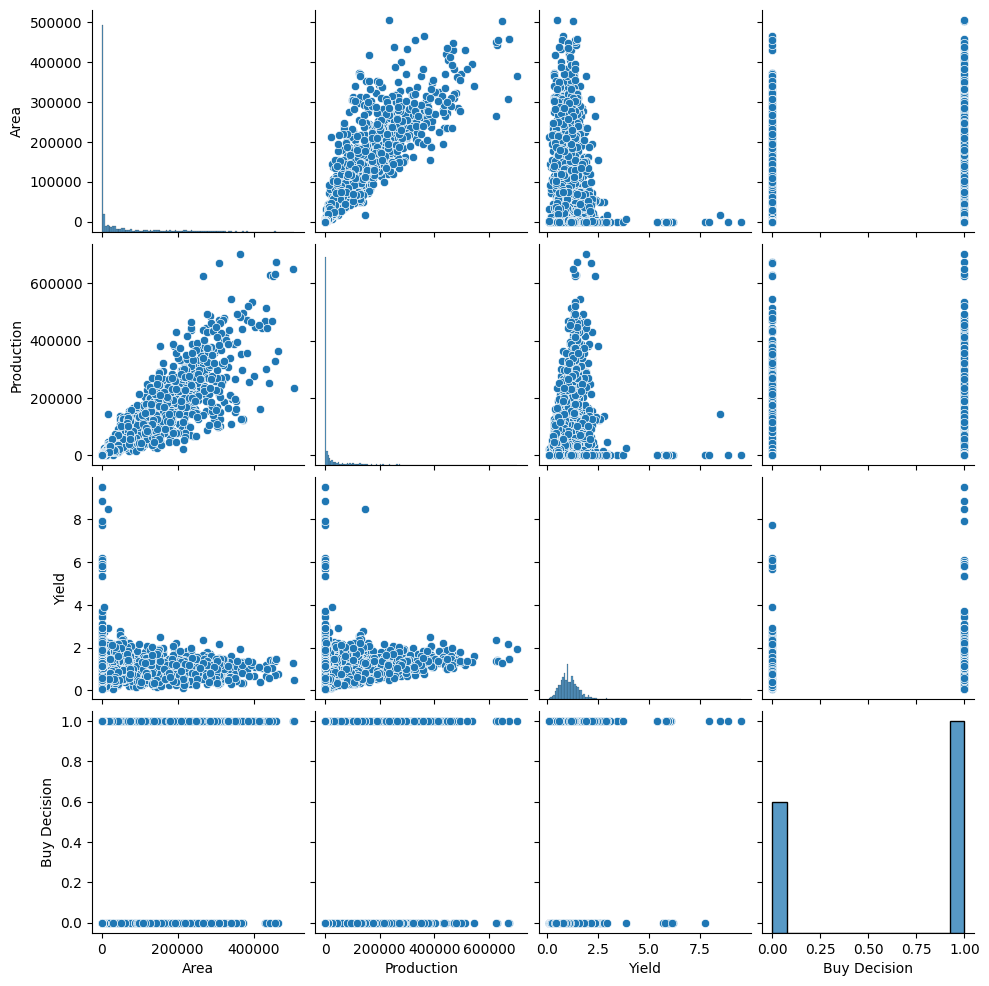

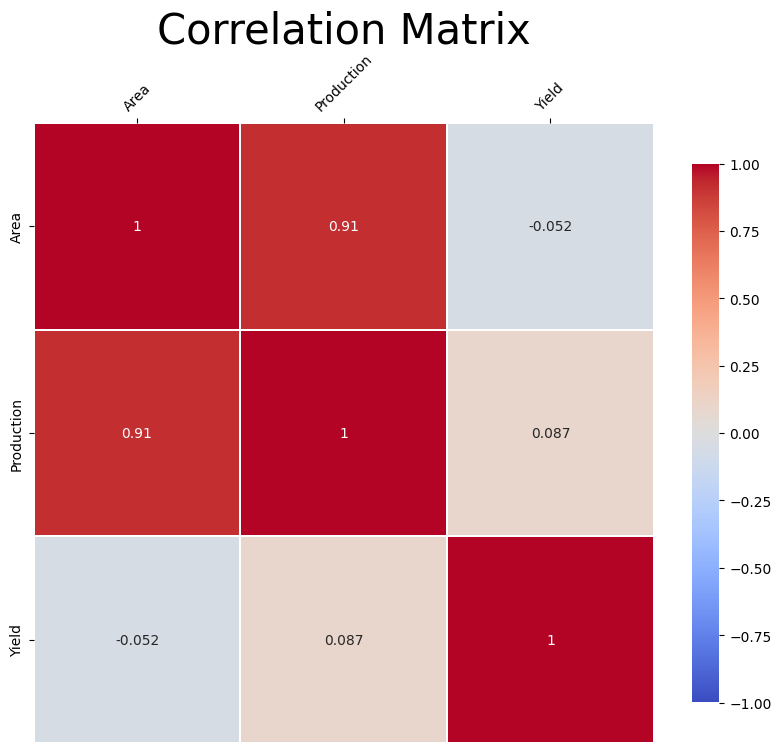

In [7]:
sns.pairplot(model_data_crop)

corr = model_data_crop.corr()

plt.subplots(figsize = (10, 10))
plt.title("Correlation Matrix", size = 30)
heatmap = sns.heatmap(corr, vmax=1, vmin = -1, annot = True, center = 0, cmap = 'coolwarm',
            square = True, linewidths = .25, cbar_kws = {"shrink": .7})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 45)
heatmap.xaxis.tick_top()

display(heatmap)

# Modeling, Results, and Analysis
As discussed in the previous sections, we will employ k-nearest neighbors and a decision tree and compare and contrast the results, and see if we can do any model improvement.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(model_data_crop.loc[:,['Area', 'Production','Yield']], model_data_crop['Buy Decision'], test_size=0.33)

Text(77.92222222222227, 0.5, 'True Labels')

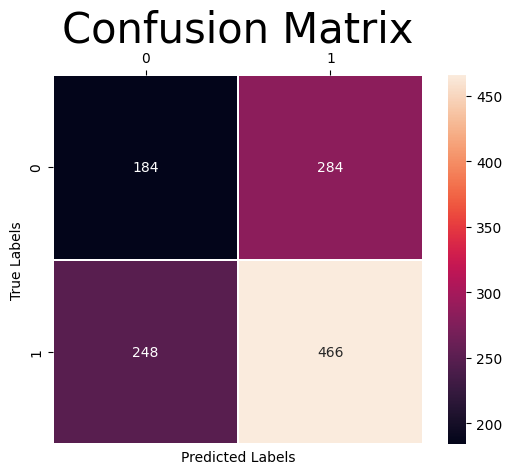

In [9]:
#build models
lab = preproc.LabelEncoder()
y_train = lab.fit_transform(y_train)
y_test = lab.fit_transform(y_test)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_hats = clf.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_true = y_test, y_pred = y_hats )

plt.subplots()
plt.title("Confusion Matrix", size = 30)
heatmap = sns.heatmap(conf_matrix, fmt = 'g', annot = True,
            square = True, linewidths = .25)
heatmap.set_xticklabels(heatmap.get_xticklabels())
heatmap.xaxis.tick_top()
heatmap.set_xlabel("Predicted Labels")
heatmap.set_ylabel("True Labels")

Text(77.92222222222227, 0.5, 'True Labels')

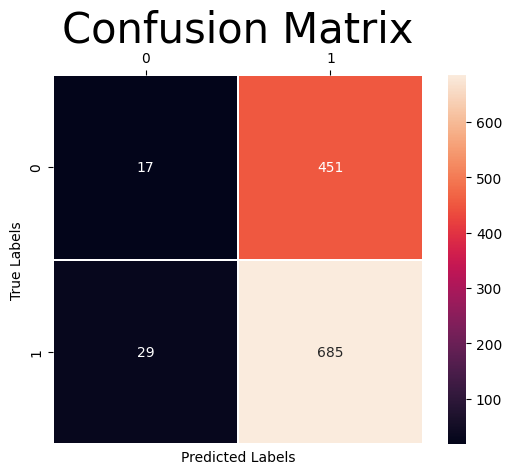

In [10]:
#try a KNN classifier
clfK = KNeighborsClassifier(n_neighbors= 50)
clfK.fit(X_train, y_train)
y_hatsK = clfK.predict(X_test)

conf_matrixK = metrics.confusion_matrix(y_true = y_test, y_pred = y_hatsK)

plt.subplots()
plt.title("Confusion Matrix", size = 30)
heatmap = sns.heatmap(conf_matrixK, fmt = 'g', annot = True,
            square = True, linewidths = .25)
heatmap.set_xticklabels(heatmap.get_xticklabels())
heatmap.xaxis.tick_top()
heatmap.set_xlabel("Predicted Labels")
heatmap.set_ylabel("True Labels")

### Model improvement attempts
Clearly our models aren't the greatest - let's see if we can find some ways to potenitally improve our performance by doing some analysis of the optimal number of KNN and seeing if AdaBoost will help us here.

Text(77.92222222222227, 0.5, 'True Labels')

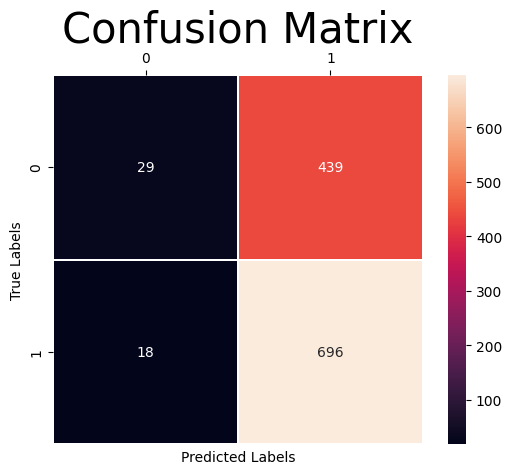

In [11]:
#try Ada Boost

clf2 = AdaBoostClassifier(n_estimators=50, random_state=0)
clf2.fit(X_train, y_train)
y_hats2 = clf2.predict(X_test)

conf_matrix2 = metrics.confusion_matrix(y_true = y_test, y_pred = y_hats2 )

plt.subplots()
plt.title("Confusion Matrix", size = 30)
heatmap = sns.heatmap(conf_matrix2, fmt = 'g', annot = True,
            square = True, linewidths = .25)
heatmap.set_xticklabels(heatmap.get_xticklabels())
heatmap.xaxis.tick_top()
heatmap.set_xlabel("Predicted Labels")
heatmap.set_ylabel("True Labels")

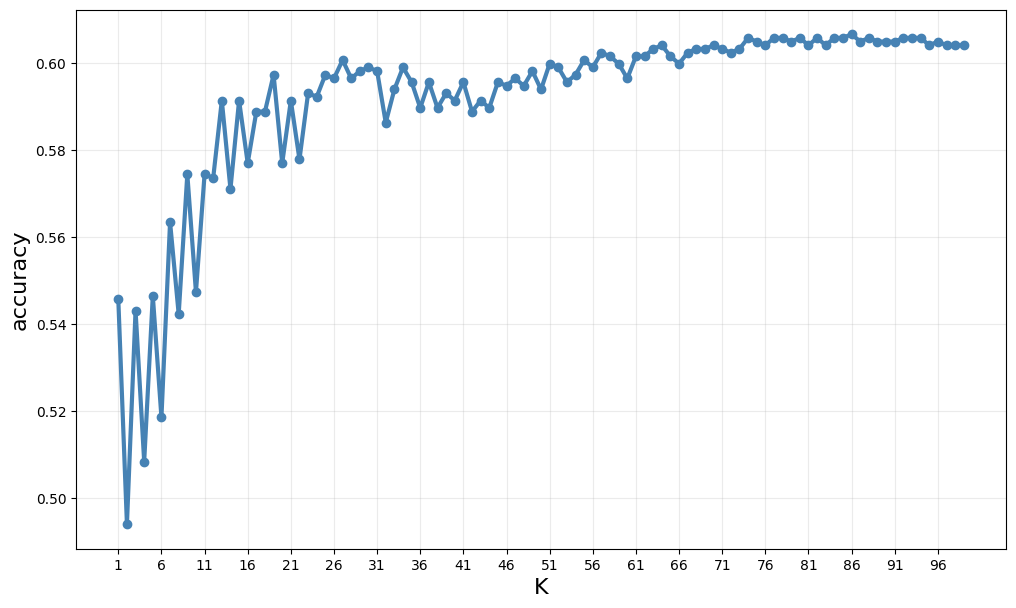

In [12]:
#try to optimize KNN (yes, these were from the module 4 assignment)
acc_scores = []
allks = range(1,100)

for k in allks:
    knn_k = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    yhat_K = knn_k.predict(X_test)
    acc_scores.append(metrics.accuracy_score(y_pred = yhat_K, y_true = y_test))
                      
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc_scores, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("K", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,100,5))
ax.grid(alpha=0.25)

Text(77.92222222222227, 0.5, 'True Labels')

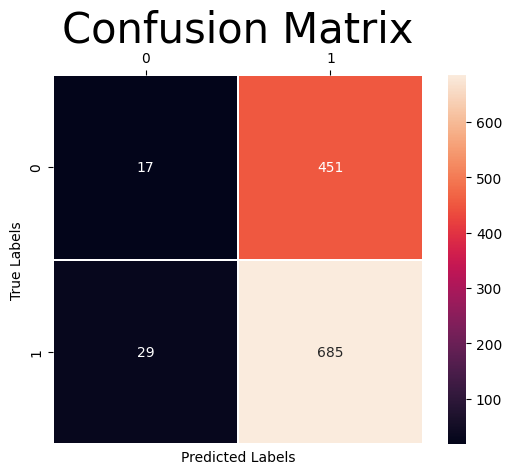

In [13]:
#re-run our KNN classifier with 66 neighbors, where our model appears to level off in terms of accuracy

clfK = KNeighborsClassifier(n_neighbors= 50)
clfK.fit(X_train, y_train)
y_hatsK = clfK.predict(X_test)

conf_matrixK = metrics.confusion_matrix(y_true = y_test, y_pred = y_hatsK)

plt.subplots()
plt.title("Confusion Matrix", size = 30)
heatmap = sns.heatmap(conf_matrixK, fmt = 'g', annot = True,
            square = True, linewidths = .25)
heatmap.set_xticklabels(heatmap.get_xticklabels())
heatmap.xaxis.tick_top()
heatmap.set_xlabel("Predicted Labels")
heatmap.set_ylabel("True Labels")

# Collinearity Issue
We definiltey have some collinearity between production and area features, let's train a model on just crop yields.

Text(77.92222222222227, 0.5, 'True Labels')

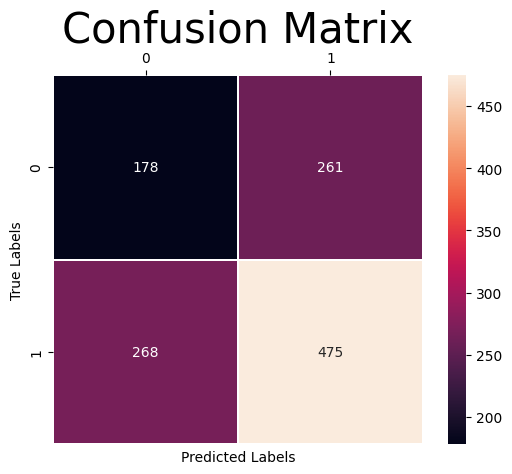

In [14]:
#build models without production and area

X_train2, X_test2, y_train2, y_test2 = train_test_split(model_data_crop.loc[:,['Area', 'Production','Yield']], model_data_crop['Buy Decision'], test_size=0.33)

lab = preproc.LabelEncoder()
y_train2 = lab.fit_transform(y_train2)
y_test2 = lab.fit_transform(y_test2)
clf_col = DecisionTreeClassifier()
clf.fit(X_train2, y_train2)
y_hats_col = clf.predict(X_test2)
conf_matrix = metrics.confusion_matrix(y_true = y_test2, y_pred = y_hats_col)

plt.subplots()
plt.title("Confusion Matrix", size = 30)
heatmap = sns.heatmap(conf_matrix, fmt = 'g', annot = True,
            square = True, linewidths = .25)
heatmap.set_xticklabels(heatmap.get_xticklabels())
heatmap.xaxis.tick_top()
heatmap.set_xlabel("Predicted Labels")
heatmap.set_ylabel("True Labels")

In [17]:
#evaluate models

data = [[metrics.accuracy_score(y_hats, y_test), metrics.accuracy_score(y_hats2, y_test), metrics.accuracy_score(y_hatsK, y_test), metrics.accuracy_score(y_hats_col, y_test)],
        [metrics.recall_score(y_hats, y_test), metrics.recall_score(y_hats2, y_test), metrics.recall_score(y_hatsK, y_test), metrics.recall_score(y_hats_col, y_test)],
       [metrics.precision_score(y_hats, y_test), metrics.precision_score(y_hats2, y_test), metrics.precision_score(y_hatsK, y_test),metrics.precision_score(y_hats_col, y_test)]]
         
df = pd.DataFrame(data, columns = ['Dec Tree', 'Ada Boost', 'KNN', "Dec Tree Drops"], index = ['Accuracy', 'Recall', 'Precision'])

print(df)

           Dec Tree  Ada Boost       KNN  Dec Tree Drops
Accuracy   0.549915   0.613367  0.593909        0.492386
Recall     0.621333   0.613216  0.602993        0.577446
Precision  0.652661   0.974790  0.959384        0.595238


# Discussion and Conclusion
In the end our model did not perform well. There are a few reasons for this:
1. Market forces are incredibly difficult to predict, it would appear that there is less of an effect of crop yields or crop production on futures pricing than originally thought.
2. While our KNN  model managed to achieve a good precision score, it is likley our models suffer from overfitting to achieve this score
3. Our features were likely limited which was anticipated, as the goal of this project was not to necessarily impliment a trading strategy, but rather to see if crop yields alone had a great enough impact on future pricing that decisions could be made. As of now it seems the answer is no.
4. There was great difficulty in obtianing data for this project. Most of the market data that would have been useful required payment
5. With some adjustments, a model similar to the one posited here could be fed into some larger model if one were to incorporate models for crop yield predictions coupled with futures forecasting models that already exist. 